# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

### Импорт библиотек

In [1]:
import pandas as pd
import os
import numpy as np

from matplotlib import pyplot
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pyplot.style.use('seaborn-deep')
STATE = np.random.RandomState(12345)

### Поиск файла и загрузка датафрейма

In [2]:
def find(name, path):
    '''
    Function to find the data file stored locally.
    Takes name of the file and root directory.
    Scanes the local directory tree for the first orrurance of the file.
    '''
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)
    

In [3]:
online_path = 'datasets'
offline_path = '/home/'
file = 'insurance.csv'


try:
    df = pd.read_csv(f'/{online_path}/{file}')
except FileNotFoundError:
    df = pd.read_csv(find(file, offline_path))
    print(f"Файл {file} найден на локальном диске.")
else:
    print(f"Файл {file} открыт в режиме online.")

Файл insurance.csv найден на локальном диске.


### Развёрнутая сводка по датафрейму

In [4]:
start = "\033[1m"
end = "\033[0;0m"
print(
        f"Внешний вид первых пяти строк датафрейма {start}{str(file).split('.')[0].upper()}{end}:"
    )
display(df.head())
print()
print(f"Размер датафрейма {start}{str(file).split('.')[0].upper()}{end}: \
        \nколичество строк - {df.shape[0]}, \nколичество столбцов - {df.shape[1]}."
          )
print()
print(
        f"Развернутая сводка датафрейма {start}{str(file).split('.')[0].upper()}{end} \nпо наименованию столбцов, типу данных, ненулевых значениях и объему памяти:"
    )
print()
df.info(show_counts=True, memory_usage='deep')
display(df.describe(include='all'))

Внешний вид первых пяти строк датафрейма INSURANCE:


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.000,49600.000,1,0
1,0,46.000,38000.000,1,1
2,0,29.000,21000.000,0,0
3,0,21.000,41700.000,2,0
4,1,28.000,26100.000,0,0



Размер датафрейма INSURANCE:         
количество строк - 5000, 
количество столбцов - 5.

Развернутая сводка датафрейма INSURANCE 
по наименованию столбцов, типу данных, ненулевых значениях и объему памяти:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000,5000.000,5000.000,5000.000,5000.000
mean,0.499,30.953,39916.360,1.194,0.148
std,0.500,8.441,9900.084,1.091,0.463
min,0.000,18.000,5300.000,0.000,0.000
25%,0.000,24.000,33300.000,0.000,0.000
50%,0.000,30.000,40200.000,1.000,0.000
75%,1.000,37.000,46600.000,2.000,0.000
max,1.000,65.000,79000.000,6.000,5.000


### *Промежуточные выводы*

Датафрейм не содержит пропусков. Так как данные не персонифицированы, то возможно наличие полностью совпадающих строк. Поэтому их поиск и пропуск не представляются логичными. Столбец **Возраст** содержит вещественные значения - необходимо исправить на цельночисленные значения. 

### Изменение типа данных

In [5]:
df['Возраст'] = df['Возраст'].astype(int)

In [6]:
# проверим полученный результат: 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   int64  
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


### Корреляция данных датафрейма

Text(0.5, 1.0, 'Корреляция параметров датафрейма')

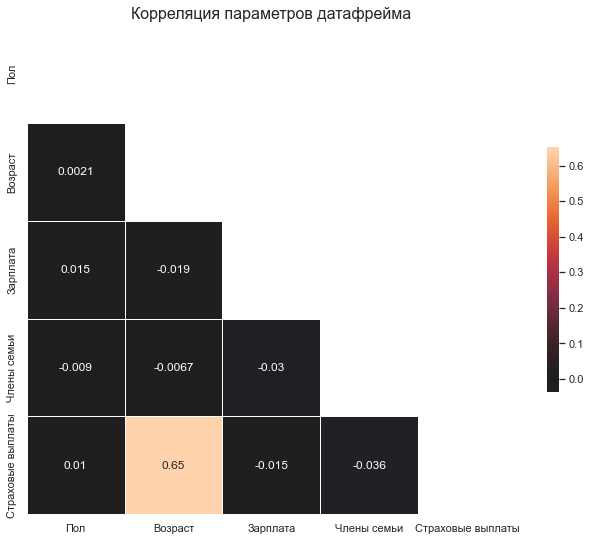

In [7]:
# рассчитаем корреляцию параметров:
corr = df.corr()

# создадим маску верхнего треугольника
mask = np.triu(np.ones_like(corr, dtype=bool))

# зададим размеры фигуры matplotlib
sns.set_theme(style="white")
f, ax = pyplot.subplots(figsize=(11, 9))

# создадим тепловую карту: 
sns.heatmap(corr,
            mask=mask,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5}, 
            annot=True)
ax.set_title(f'Корреляция параметров датафрейма',
             fontsize=16)

### *Промежуточные выводы*

Параметры датафрейма не обнаруживают корреляцию, кроме средней степени зависимости количества страховых выплат от возраста. 

### Разделение выборки на целевой признак и параметры 

In [8]:
features = df.iloc[:, :-1]

In [9]:
target = df.iloc[:, -1]

## Умножение матриц

Для кодирования данных датасета используем умножение исходной матрицы на случайную обратимую матрицу.  

### Случайная обратимая матрица

In [10]:
# создание случайной квадратной матрицы:
rand_matrix = np.random.randint(1,5,(4,4)) 

In [11]:
# проверим полученный результат: 
rand_matrix

array([[4, 4, 4, 2],
       [2, 4, 4, 3],
       [4, 1, 4, 1],
       [4, 2, 1, 2]])

In [12]:
# получим матрицу, обратную случайной: 
inverted_matrix = np.linalg.inv(rand_matrix)

In [13]:
# проверим полученный результат: 
inverted_matrix

array([[ 0.109375, -0.21875 ,  0.0625  ,  0.1875  ],
       [ 0.59375 , -0.1875  , -0.375   , -0.125   ],
       [-0.0625  ,  0.125   ,  0.25    , -0.25    ],
       [-0.78125 ,  0.5625  ,  0.125   ,  0.375   ]])

Проверим равенство: 
$$
(A * B)^T = B^T * A^T
$$


In [14]:
(rand_matrix @ inverted_matrix).T == inverted_matrix.T @ rand_matrix.T

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

### Умножение матриц

In [15]:
coded_data = features @ rand_matrix

$$
w' = (P^T (X^T X) P)^{-1} (XP)^T y
$$
$$
w' = (P^T (X^T X) P)^{-1} P^T X^T y
$$
$$
w' = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$
$$
w' = P^{-1} (X^T X)^{-1} E X^T y
$$
\
$$
w' = P^{-1}w
$$

## Алгоритм преобразования

**Алгоритм**

Матрица исходных данных умножается на случайную обратимую матрицу. При этом высота случайной матрицы должна соответствовать ширине матрицы с исходными данными, а ширина случайной матрицы должна быть равна ее высоте (квадратная матрица). 

**Обоснование**

Этот метод позволит закодировать персональные данные пользователей, что позволит использовать их в дальнейшей работе без риска потери качества работы модели машинного обучения и утечки персональных данных. <br><br>Для восстановления первоначальных данных, в случае необходимости, используется обратная матрица - закодированная матрица умножается на обратную матрицу *inverted_matrix*.

## Проверка алгоритма

### Обучение модели линейной регрессии на исходном датасете

In [16]:
# обучение модели и получение предсказаний:
model = LinearRegression()
model.fit(features, target)
predictions_valid = model.predict(features)
result = r2_score(target, predictions_valid)

In [17]:
print(result)

0.42494550286668


### Обучение модели линейной регрессии на закодированных данных

In [18]:
# обучение модели и получение предсказаний:
model = LinearRegression()
model.fit(coded_data, target)
predictions_valid = model.predict(coded_data)
result = r2_score(target, predictions_valid)

In [19]:
print(result)

0.42494550286668087


## Вывод

Метод умножения исходной матрицы на случайную обратимую матрицу позволяет закодировать персональные данные пользователей для использования их в дальнейшей работе без риска потери качества работы модели машинного обучения и утечки персональных данных.